In [2]:
!pip install gudhi
!pip install giotto-tda
!pip install ripser

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.9 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18102 sha256=7b4a44e7b9ab9dcf901dcf31c3c1cd5497c0813ae3766318f6ed6c1f4844ac30
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive
import os

import cv2
from google.colab.patches import cv2_imshow
import _pickle as cPickle

import gudhi as gd
from gudhi.hera import wasserstein_distance
from gtda.homology import VietorisRipsPersistence
from gtda.time_series import SlidingWindow

from ripser import ripser, Rips

In [4]:
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/climb")

Mounted at /content/drive


In [5]:
## function block

def plot_persistence(l):
    """
    Takes list and plots each element in the list on its own graph.
    """
    for i in range(len(l)):
        plt.plot(l[i])
        plt.title(f"{i}-D")
        plt.show()

def convert_to_grayscale(video_path, bool_resize=False, downsized_pixels=(1920,1080)):
    """
    Converts each frame of a video to grayscale and saves the new video.
    Option to downsize the video.

    Args:
        video_path (str): Path to the input video file.
        bool_resize (bool, optional): Whether to downsize the video.
            Defaults to False.
        downsized_pixels (tuple, optional): Dimensions for downsizing the video.
            Defaults to (1920, 1080), but method uses the input video's dimensions.

    Returns:
        None. Saves a grayscale copy of the input video to the same directory
        as the input video with the output f'gray_{video_path}'.
    """

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return

    if bool_resize:
        frame_width = downsized_pixels[0]
        frame_height = downsized_pixels[1]
    else:
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_path = f"gray_{video_path}"
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height), isColor=False)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if bool_resize:
            gray_frame = gray_frame[0:frame_height, 0:frame_width]

        out.write(gray_frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    if bool_resize:
        print(f"Successfully converted to grayscale and downsized to {downsized_pixels} as: {output_path}")
    else:
        print(f"Successfully converted to grayscale as: {output_path}")

def video_to_numeric(files, print_state=True):
    """
    Converts grayscale video files to a list of numpy arrays.

    Args:
        files (list of str): file names of videos in directory to convert.
        Assumes each video is the same size (by dimension, not length).

    Returns:
        list of numpy arrays, each a conversion of the grayscale video files.
    """
    output_list = []

    for file in files:
        frames_data = []

        cap = cv2.VideoCapture(file)

        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        if not cap.isOpened():
            print(f"Error: Could not open video file: {file}")
            return

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frames_data.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        if print_state:
            print(f"file {file} successfully converted to numpy.")
        output_list.append(np.asarray(frames_data))

    return output_list

def video_concatenation(file, begin_frame_cut=0, end_frame_cut=1000, print_frame=True):
    """
    Crops a video file from the front and back at the specified frame cutoffs.

    Args:
        file (str): Path to the input video file.
        end_frame_cut (int, optional): Number of frames to remove from the end of the video.
            Defaults to 1000.
        begin_frame_cut (int, optional): Number of frames to remove from the beginning of the video.
            Defaults to 0.
        print_frame (bool, optional): Whether to print the first and final frames.
            Defaults to True.

    Returns:
        None. Saves a cropped copy of the input video to the same directory
        as the input video with the output f'cropped_{file}'.
    """

    max_frame = video_to_numeric([file], print_state=False)[0].shape[0]
    print(f"{file} max frame: {max_frame}")

    cap = cv2.VideoCapture(file)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {file}")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_path = f"cropped_{file}"
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height), isColor=False)

    i = 0

    while True and i<end_frame_cut:
        ret, frame = cap.read()
        if not ret:
            break

        if i<begin_frame_cut-1:
            i+=1
            continue
        else:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            out.write(frame)

        i+=1

        ## shows first and last frames added to the cropped video
        if print_frame and i==begin_frame_cut:
            print(i)
            cv2_imshow(frame)
        elif print_frame and i==end_frame_cut:
            print(i)
            cv2_imshow(frame)


    print(f"file {file} successfully cropped to {i-begin_frame_cut} frames.")
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [8]:
"""
List of files to downsize and grayscale (current list for Will Bosi's Burden of Dreams first move only).
All are in .mp4 format, so the loop formatting is done as such.

crop_dim is a set aligned with each video to determine the proper place to cut the videos
(front and back), such that the first frame is when his butt leaves the ground and the last
frame is when his hand hits the hold.

success is a set aligned with each video stating 0 if Will failed the move, or 1 if he succeeded.
"""

# vals for indexes
# Livestream 1 (0,1,2)
# Livestream 2 (3,4)
# Livestream 3 (5,6,7,8,9,10,11,12)

files = ['1.1','1.2','1.3','2.1','2.2','3.1','3.2','3.3','3.4','3.5','3.6','3.7','3.8']

crop_dim = [[25,89],[10,68],[20,77],[1,56],[1,51],[12,73],[15,79],[1,60],[14,81],[12,72],[9,73],[6,70],[1,65]]

success = [0,0,1,0,0,0,0,0,1,1,0,1,0]

In [9]:
"""
Only need to run once to get grayscale files in directory.
One should wait before running the next cell to allow the files to be processed.
"""
gray_files = []
for file in files:
    # convert_to_grayscale(f'{file}.mp4', True, [480,480])
    gray_files.append(f'gray_{file}.mp4')

cropped_files = []
for file in gray_files:
    # video_concatenation(file, crop_dim[gray_files.index(file)][0],
    #                    crop_dim[gray_files.index(file)][1], False)
    cropped_files.append(f'cropped_{file}')

In [10]:
"""
X is a list of numpy arrays, each a conversion of a grayscale video file.
Shape of X[i] is (frames, height, width)
"""
X = video_to_numeric(cropped_files)

"""
potential reshaping of X to (frames, height*width)
"""
reshaping = False
for i in range(len(X)):
    if reshaping:
        X[i] = X[i].reshape(X[i].shape[0], X[i].shape[1]*X[i].shape[2])
    print(X[i].shape)

file cropped_gray_1.1.mp4 successfully converted to numpy.
file cropped_gray_1.2.mp4 successfully converted to numpy.
file cropped_gray_1.3.mp4 successfully converted to numpy.
file cropped_gray_2.1.mp4 successfully converted to numpy.
file cropped_gray_2.2.mp4 successfully converted to numpy.
file cropped_gray_3.1.mp4 successfully converted to numpy.
file cropped_gray_3.2.mp4 successfully converted to numpy.
file cropped_gray_3.3.mp4 successfully converted to numpy.
file cropped_gray_3.4.mp4 successfully converted to numpy.
file cropped_gray_3.5.mp4 successfully converted to numpy.
file cropped_gray_3.6.mp4 successfully converted to numpy.
file cropped_gray_3.7.mp4 successfully converted to numpy.
file cropped_gray_3.8.mp4 successfully converted to numpy.
(65, 480, 480)
(59, 480, 480)
(58, 480, 480)
(56, 480, 480)
(51, 480, 480)
(62, 480, 480)
(65, 480, 480)
(60, 480, 480)
(68, 480, 480)
(61, 480, 480)
(65, 480, 480)
(65, 480, 480)
(65, 480, 480)


In [12]:
# Sliding Window approach

x=X[5]
n1 = x.shape[0]
n2 = x.shape[1] * x.shape[2]
x = x.reshape((n1,n2))

wind = SlidingWindow(size=2,stride=1)
temp = wind.fit(x)

In [13]:
temp.shape

AttributeError: 'SlidingWindow' object has no attribute 'shape'

In [ ]:
# pickling the persistence of each video

def persistence_pickling(hom, file_name):
    """
    Takes a Gudhi homology class with persistence computed
    and saves it to drive as a pickle file.
    """
    persistence = [hom.persistence_intervals_in_dimension(0),
                   hom.persistence_intervals_in_dimension(1),
                   hom.persistence_intervals_in_dimension(2)]
    with open(f"{file_name}_pers.pickle", "wb") as output_file:
        cPickle.dump(persistence, output_file)
        print(f"Successfully saved {file_name} as a pickle file!")
        output_file.close()



runPickle = False
if runPickle:
    for i in range(len(X)):
        hom = gd.CubicalComplex(vertices = X[i])
        hom.compute_persistence()
        persistence_pickling(hom, f"{files[i]}")


Successfully saved 1.1 as a pickle file!
Successfully saved 1.2 as a pickle file!
Successfully saved 1.3 as a pickle file!
Successfully saved 2.1 as a pickle file!
Successfully saved 2.2 as a pickle file!
Successfully saved 3.1 as a pickle file!
Successfully saved 3.2 as a pickle file!
Successfully saved 3.3 as a pickle file!
Successfully saved 3.4 as a pickle file!
Successfully saved 3.5 as a pickle file!
Successfully saved 3.6 as a pickle file!
Successfully saved 3.7 as a pickle file!
Successfully saved 3.8 as a pickle file!


In [ ]:
# wasserstein and bottleneck block. Requires the picked files

def distances(pers1, pers2):
    """
    Calculates the Wasserstein and Bottleneck distances between two persistence intervals.
    Args:
        pers1 (np.array of shape (m,2)),
        pers2 (np.array of shape (n,2)):
            persistence intervals to compare.
    Returns:
        dists (list, [wasserstein (float), bottleneck (float)]):
            list of the calculated distances.
    """
    dists = []
    # takes roughly two minutes
    wass = wasserstein_distance(pers1, pers2)
    dists.append(wass)
    # takes roughly 10 seconds
    bott = gd.bottleneck_distance(pers1, pers2)
    dists.append(bott)
    return dists

runDists = False
if runDists:
    dim0_dists = []
    dim1_dists = []
    dim2_dists = []
    for i in range(5,len(files)):
        for j in range(i+1,len(files)):

            temp1 = cPickle.load(open(f"{files[i]}_pers.pickle", "rb"))
            temp2 = cPickle.load(open(f"{files[j]}_pers.pickle", "rb"))

            dim0_dists.append(distances(temp1[0], temp2[0]))
            dim1_dists.append(distances(temp1[1], temp2[1]))
            dim2_dists.append(distances(temp1[2], temp2[2]))

            print(f"{files[i]} and {files[j]} done!")

    print(dim0_dists)
    print(dim1_dists)
    print(dim2_dists)

3.1 and 3.2 done!
3.1 and 3.3 done!
3.1 and 3.4 done!
3.1 and 3.5 done!
3.1 and 3.6 done!
3.1 and 3.7 done!
3.1 and 3.8 done!
3.2 and 3.3 done!
3.2 and 3.4 done!
3.2 and 3.5 done!
3.2 and 3.6 done!
3.2 and 3.7 done!
3.2 and 3.8 done!
3.3 and 3.4 done!
3.3 and 3.5 done!
3.3 and 3.6 done!
3.3 and 3.7 done!
3.3 and 3.8 done!
3.4 and 3.5 done!
3.4 and 3.6 done!
3.4 and 3.7 done!
3.4 and 3.8 done!
3.5 and 3.6 done!
3.5 and 3.7 done!
3.5 and 3.8 done!
3.6 and 3.7 done!
3.6 and 3.8 done!
3.7 and 3.8 done!
[[12374.5, 18.0], [16108.5, 29.0], [23380.0, 21.0], [16446.5, 20.999999999999993], [26114.0, 19.0], [19258.0, 25.0], [20579.0, 21.0], [9874.5, 25.0], [26322.5, 19.0], [14382.5, 19.0], [27783.0, 19.0], [21065.0, 17.0], [18844.0, 16.999999999999993], [26196.5, 16.999999999999996], [12948.5, 21.0], [27702.5, 16.0], [21111.0, 17.0], [17106.5, 20.0], [17835.5, 14.0], [12497.5, 11.999999999999998], [10398.0, 14.000000000000002], [15849.5, 14.0], [18204.5, 17.0], [13553.5, 14.0], [10500.0, 15.99999

## Raw data and Analysis below

Session 1 Distances:

Wasserstein:

0-Dim
\begin{blockarray}{cccc}
& 1.1 & 1.2 & 1.3 \\
\begin{block}{c[ccc]}
1.1 & 0, 45186, 25645 \\
1.2 & 45186, 0, 33988 \\
1.3 & 25645, 33988, 0
\end{block}
\end{blockarray}

1-Dim
\begin{bmatrix} 0, 62158, 25607 \\
62158, 0, 49847 \\
25607, 49847, 0
\end{bmatrix}

2-Dim
\begin{bmatrix}
0, 22746, 9835 \\
22746, 0, 19568 \\
9835, 19568, 0
\end{bmatrix}

Bottleneck:

0-Dim
\begin{bmatrix}
0, 24, 14 \\
24, 0, 22 \\
14, 22, 0
\end{bmatrix}

1-Dim
\begin{bmatrix} 0, 29, 28 \\
29, 0, 35 \\
28, 35, 0
\end{bmatrix}

2-Dim
\begin{bmatrix} 0, 24, 41 \\
24, 0, 26 \\
41, 26, 0
\end{bmatrix}



Stream 3:

0-dim

[[12374.5, 18.0], [16108.5, 29.0], [23380.0, 21.0], [16446.5, 20.999999999999993], [26114.0, 19.0], [19258.0, 25.0], [20579.0, 21.0], [9874.5, 25.0], [26322.5, 19.0], [14382.5, 19.0], [27783.0, 19.0], [21065.0, 17.0], [18844.0, 16.999999999999993], [26196.5, 16.999999999999996], [12948.5, 21.0], [27702.5, 16.0], [21111.0, 17.0], [17106.5, 20.0], [17835.5, 14.0], [12497.5, 11.999999999999998], [10398.0, 14.000000000000002], [15849.5, 14.0], [18204.5, 17.0], [13553.5, 14.0], [10500.0, 15.999999999999998], [11429.5, 12.0], [16778.5, 11.0], [12789.5, 10.999999999999996]]

1-dim

[[26121.5, 28.0], [30973.0, 37.0], [37708.0, 38.999999999999986], [29568.0, 35.0], [37654.5, 35.0], [30827.5, 32.00000000000001], [31228.5, 33.000000000000014], [13039.0, 32.0], [32608.5, 36.0], [16473.0, 33.0], [33791.5, 34.0], [26410.0, 25.0], [19081.5, 30.0], [34542.0, 30.0], [16246.0, 20.999999999999996], [35473.5, 24.999999999999996], [28732.5, 22.0], [18572.0, 23.0], [22826.0, 17.999999999999996], [15220.0, 12.0], [13606.0, 19.0], [23743.5, 21.999999999999993], [23186.5, 20.999999999999993], [18598.5, 19.0], [11185.5, 16.0], [16045.5, 22.999999999999993], [25121.5, 19.999999999999996], [19897.0, 24.0]]

2-dim

[[12349.0, 28.0], [14299.0, 29.999999999999993], [12657.5, 34.99999999999999], [12240.5, 35.0], [12634.0, 39.00000000000001], [11494.0, 37.0], [11790.5, 25.999999999999996], [5053.0, 14.0], [9211.0, 12.999999999999996], [6669.5, 16.0], [9554.0, 25.0], [7656.5, 15.0], [7487.0, 16.999999999999993], [10191.5, 17.0], [6520.5, 18.999999999999993], [10097.0, 21.0], [8857.0, 10.0], [7411.0, 18.0], [6635.0, 19.0], [6043.0, 17.999999999999996], [5409.0, 14.000000000000002], [7511.5, 15.0], [6754.0, 19.0], [6333.0, 16.0], [4825.0, 17.0], [6187.5, 22.0], [7556.5, 18.0], [7241.0, 22.0]]

In [ ]:
# Output of distance data from Stream 3

Dim_0 = [[12374.5, 18.0], [16108.5, 29.0], [23380.0, 21.0], [16446.5, 21.0], [26114.0, 19.0], [19258.0, 25.0], [20579.0, 21.0],
        [9874.50, 25.0], [26322.5, 19.0], [14382.5, 19.0], [27783.0, 19.0], [21065.0, 17.0], [18844.0, 17.0], [26196.5, 17.0],
        [12948.5, 21.0], [27702.5, 16.0], [21111.0, 17.0], [17106.5, 20.0], [17835.5, 14.0], [12497.5, 12.0], [10398.0, 14.0],
        [15849.5, 14.0], [18204.5, 17.0], [13553.5, 14.0], [10500.0, 16.0], [11429.5, 12.0], [16778.5, 11.0], [12789.5, 11.0]]

Dim_1 = [[26121.5, 28.0], [30973.0, 37.0], [37708.0, 39.0], [29568.0, 35.0], [37654.5, 35.0], [30827.5, 32.0], [31228.5, 33.0],
        [13039.0, 32.0], [32608.5, 36.0], [16473.0, 33.0], [33791.5, 34.0], [26410.0, 25.0], [19081.5, 30.0], [34542.0, 30.0],
        [16246.0, 21.0], [35473.5, 25.0], [28732.5, 22.0], [18572.0, 23.0], [22826.0, 18.0], [15220.0, 12.0], [13606.0, 19.0],
        [23743.5, 22.0], [23186.5, 21.0], [18598.5, 19.0], [11185.5, 16.0], [16045.5, 23.0], [25121.5, 20.0], [19897.0, 24.0]]

Dim_2 = [[12349.0, 28.0], [14299.0, 30.0], [12657.5, 35.0], [12240.5, 35.0], [12634.0, 39.0], [11494.0, 37.0], [11790.5, 26.0],
        [5053.0, 14.0], [9211.0, 13.0], [6669.5, 16.0], [9554.0, 25.0], [7656.5, 15.0], [7487.0, 17.0], [10191.5, 17.0],
        [6520.5, 19.0], [10097.0, 21.0], [8857.0, 10.0], [7411.0, 18.0], [6635.0, 19.0], [6043.0, 18.0], [5409.0, 14.0],
        [7511.5, 15.0], [6754.0, 19.0], [6333.0, 16.0], [4825.0, 17.0], [6187.5, 22.0], [7556.5, 18.0], [7241.0, 22.0]]


# here we attempt to get statistics based on the difference between a success and failure between videos
st3_succ = [0, 0, 0, 1, 1, 0, 1, 0]
n = len(st3_succ)
m=0
data = []

# making the dataframe:
# taret, wass_0, wass_1, wass_2, bott_0, bott_1, bott_2
for i in range(n):
    for j in range(i+1,n):

        # score determines the parity of succ vs succ (2), succ vs fail (1), or fail vs fail (0) between videos
        score = st3_succ[i] + st3_succ[j]
        data.append([score,Dim_0[m][0],Dim_1[m][0],Dim_2[m][0],Dim_0[m][1],Dim_1[m][1],Dim_2[m][1]])

        m += 1

Data = pd.DataFrame(data, columns = ['target', 'wass_0', 'wass_1', 'wass_2', 'bott_0', 'bott_1', 'bott_2'])
print(Data)



    target   wass_0   wass_1   wass_2  bott_0  bott_1  bott_2
0        0  12374.5  26121.5  12349.0    18.0    28.0    28.0
1        0  16108.5  30973.0  14299.0    29.0    37.0    30.0
2        1  23380.0  37708.0  12657.5    21.0    39.0    35.0
3        1  16446.5  29568.0  12240.5    21.0    35.0    35.0
4        0  26114.0  37654.5  12634.0    19.0    35.0    39.0
5        1  19258.0  30827.5  11494.0    25.0    32.0    37.0
6        0  20579.0  31228.5  11790.5    21.0    33.0    26.0
7        0   9874.5  13039.0   5053.0    25.0    32.0    14.0
8        1  26322.5  32608.5   9211.0    19.0    36.0    13.0
9        1  14382.5  16473.0   6669.5    19.0    33.0    16.0
10       0  27783.0  33791.5   9554.0    19.0    34.0    25.0
11       1  21065.0  26410.0   7656.5    17.0    25.0    15.0
12       0  18844.0  19081.5   7487.0    17.0    30.0    17.0
13       1  26196.5  34542.0  10191.5    17.0    30.0    17.0
14       1  12948.5  16246.0   6520.5    21.0    21.0    19.0
15      

In [ ]:
ff = Data[Data['target']==0].drop('target', axis=1)
fs = Data[Data['target']==1].drop('target', axis=1)
ss = Data[Data['target']==2].drop('target', axis=1)

In [ ]:
ff.describe()

,wass_0,wass_1,wass_2,bott_0,bott_1,bott_2
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,19326.500000,27105.650000,9823.100000,19.500000,29.700000,23.600000
std,6227.076387,8150.938859,2934.470015,4.904646,5.578729,7.530678
min,9874.500000,13039.000000,5053.000000,11.000000,20.000000,14.000000
25%,16276.000000,20591.500000,7504.375000,17.250000,25.750000,18.000000
50%,17975.250000,28547.250000,9825.500000,19.000000,31.000000,23.000000
75%,24730.250000,33150.750000,12209.375000,20.750000,33.750000,27.500000
max,27783.000000,37654.500000,14299.000000,29.000000,37.000000,39.000000


In [ ]:
fs.describe()

,wass_0,wass_1,wass_2,bott_0,bott_1,bott_2
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,17492.066667,24159.566667,8270.666667,17.266667,26.066667,20.666667
std,5242.057001,8095.438411,2411.681694,3.918211,7.759480,8.363754
min,10500.000000,11185.500000,4825.000000,11.000000,12.000000,10.000000
25%,12869.000000,16359.500000,6595.000000,15.000000,21.500000,15.500000
50%,16446.500000,23743.500000,7511.500000,17.000000,24.000000,18.000000
75%,21088.000000,30197.750000,9701.250000,20.000000,32.500000,22.000000
max,26322.500000,37708.000000,12657.500000,25.000000,39.000000,37.000000


In [ ]:
ss.describe()

,wass_0,wass_1,wass_2,bott_0,bott_1,bott_2
count,3.000000,3.000000,3.000000,3.0,3.000000,3.000000
mean,13929.000000,18343.500000,6125.666667,14.0,18.666667,16.333333
std,3732.941434,4615.286421,638.756083,0.0,0.577350,2.516611
min,10398.000000,13606.000000,5409.000000,14.0,18.000000,14.000000
25%,11975.750000,16102.250000,5871.000000,14.0,18.500000,15.000000
50%,13553.500000,18598.500000,6333.000000,14.0,19.000000,16.000000
75%,15694.500000,20712.250000,6484.000000,14.0,19.000000,17.500000
max,17835.500000,22826.000000,6635.000000,14.0,19.000000,19.000000


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

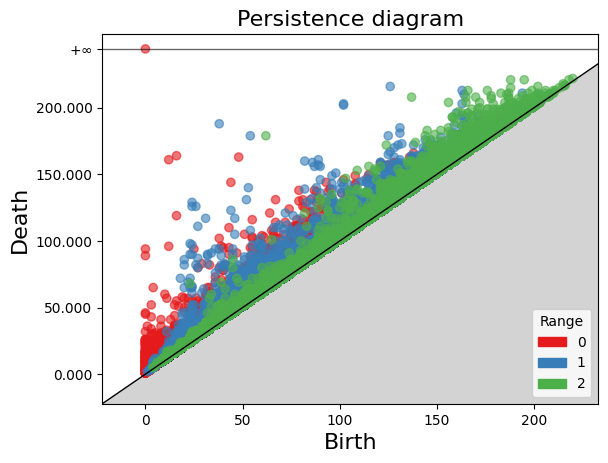

In [ ]:
# Plotting persistence block

# success = [0,0,1,0,0,0,0,0,1,1,0,1,0]

temp = cPickle.load(open(f"3.3_pers.pickle", "rb"))
gd.plot_persistence_diagram(temp)

In [ ]:
# finding the average length of the one-dimensional intervals, since they seemed interesting

def desc_length(intervals, min_length=0, title="n"):
    """
    Takes the persistence intervals and returns a description of statistically
    important data regarding the lengths.

    Args:
        intervals (np.array of shape (n,2)):
            persistence intervals to compare.
        min_length (float):
            minimum length of intervals to consider. Defaults to 0.
        title (str):
            title of the diagram. Defaults to "n", which gives no title

    Returns:
        pd.describe():
            average length of intervals.
    """
    data = []

    for i in intervals:
        diff = i[1]-i[0]
        if diff == np.infty or diff <= min_length:
            continue
        data.append(diff)
    if title == "n":
        return pd.DataFrame(data, columns=[f"lengths (min_length = {min_length})"]).describe()
    else:
        return pd.DataFrame(data, columns=[f"lengths: {title} (min_length = {min_length})"]).describe()


for i in range(8):
    temp = cPickle.load(open(f"3.{i+1}_pers.pickle", "rb"))
    print(desc_length(temp[1], 30, f"3.{i+1}"))


       lengths: 3.1 (min_length = 30)
count                       92.000000
mean                        44.413043
std                         17.942002
min                         31.000000
25%                         33.000000
50%                         38.000000
75%                         47.000000
max                        132.000000
       lengths: 3.2 (min_length = 30)
count                      102.000000
mean                        47.647059
std                         18.469481
min                         31.000000
25%                         35.000000
50%                         41.000000
75%                         50.750000
max                        119.000000
       lengths: 3.3 (min_length = 30)
count                      154.000000
mean                        47.805195
std                         19.908312
min                         31.000000
25%                         34.000000
50%                         41.000000
75%                         54.000000
max         

In [ ]:
"""
Beyond here is work that is not needed or experimental.
"""
"""
"""
"""
"""
"""
"""
"""
"""
"""
"""
"""
"""
"""
"""
"""
"""
"""
"""
"""
"""
"""
"""

SyntaxError: incomplete input (<ipython-input-7-e2f66b5e76d4>, line 26)

In [ ]:
test = X[0]
change = np.asarray([0,0])
m,n = test[0].shape

# checking for pixels that change within a certain amount for the duration of the video
"""
for i in range(m):
    for j in range(n):
        pix = True
        val = test[0,i,j]
        vals = range(val-9,val+10)
        for frame in test:
            if frame[i,j] not in vals:
                pix = False
                break

        if pix:
            change[0] += 1
        else:
            change[1] += 1

print(change)
"""